## Serverless Premium with NQE

### Objective
This notebook is designed for running TPCH and TPCDS benchmarks on Serverless Premium with NQE using Serverless Interactive sessions.

### Initialize Public GCS Bucket
This initializes the public GCS bucket from which datasets and utilities will be copied to your GCS bucket.

In [1]:
SOURCE_PUBLIC_GCS_BUCKET = "tpc-benchmarking-kit-bucket"

### Initialization Setup

In [2]:
import re
import subprocess
from typing import Tuple
import json
import requests

# Returns name of current project
def get_gcloud_project():
    try:
        command = ["gcloud", "config", "get", "project"]
        process = subprocess.run(command, capture_output=True, text=True, check=True)
        project_name = process.stdout.strip()
        return project_name
    except subprocess.CalledProcessError as e:
        raise ValueError(f"Error getting gcloud project: {e}\nStdout: {e.stdout}\nStderr: {e.stderr}")
    except FileNotFoundError:
        raise ValueError("Error: gcloud command not found. Make sure the Google Cloud CLI is installed and in your system's PATH.")

# Retrieves the current region in use
def get_gcloud_region():
    metadata_url = "http://metadata.google.internal/computeMetadata/v1/instance/zone"
    headers = {"Metadata-Flavor": "Google"}

    try:
        response = requests.get(metadata_url, headers=headers, timeout=5)
        response.raise_for_status() 
        zone = response.text.split('/')[-1]
        region = '-'.join(zone.split('-')[:-1])
        return region
    except requests.exceptions.RequestException as e:
        print(f"Could not retrieve region from metadata server: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Returns project number of current project
def get_project_number(project_id: str) -> str:
    try:
        command = [
            "gcloud",
            "projects",
            "describe",
            project_id,
            "--format=value(projectNumber)",
        ]
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        project_number = result.stdout.strip()
        return project_number
    except subprocess.CalledProcessError as e:
        raise ValueError(f"Error executing gcloud command for project ID '{project_id}': {e}\nStderr: {e.stderr}")
    except FileNotFoundError:
        raise ValueError("Error: gcloud CLI not found. Make sure it's installed and in your system's PATH.")

PROJECT = get_gcloud_project()
PROJECT_NUMBER = get_project_number(PROJECT)
REGION = get_gcloud_region()
TIER = "premium"
RUNTYPE = "native"

TPCH_TABLES = ["customer", "lineitem", "nation", "orders", "part", "partsupp", "region", "supplier"]
TPCDS_TABLES = ["call_center", "catalog_page", "catalog_returns", "catalog_sales", "customer", "customer_address", "customer_demographics", "date_dim", "household_demographics", "income_band", "inventory", "item", "promotion", "reason", "ship_mode", "store", "store_returns", "store_sales", "time_dim", "warehouse", "web_page", "web_returns", "web_sales", "web_site"]

print(f"Current Google Cloud Project:{PROJECT}")
print(f"Current Project Number: {PROJECT_NUMBER}")
print(f"Current Region: {REGION}")

Current Google Cloud Project:nishitkamdarargo
Current Project Number: 279814974066
Current Region: us-east1


### Initialize your GCS Bucket
To run the benchmarks, a Google Cloud Storage (GCS) bucket is required to store necessary utilities.

The default GCS bucket name is `sparkpoc-bucket-serverless-premium-nqe-PROJECT_NUMBER-REGION`. You can use a different bucket name as needed.

**NOTE - The following cell will attempt to create a storage bucket. If a bucket with this name already exists in the specified region and you own it, you might see a "bucket name taken" message or a confirmation of a previous creation. You can safely ignore these messages if your desired bucket is already created. Otherwise, please choose a unique bucket name and try again.**

In [3]:
BUCKET_NAME = f"sparkpoc-bucket-serverless-premium-nqe-{PROJECT_NUMBER}-{REGION}"
print(f"GCS Bucket Name: {BUCKET_NAME}")

GCS Bucket Name: sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1


In [4]:
! gcloud storage buckets create gs://{BUCKET_NAME} --uniform-bucket-level-access --location={REGION}

Creating gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/...


### Benchmark Configuration Setup

This step initializes the benchmark configurations. These configurations define the parameters for the benchmark run, such as:

- **Benchmark:** The type of benchmark to run (e.g., "tpch",  "tpcds",  "tpch,tpcds",  "tpcds,tpch").
- **TPCH Queries to Run:** The specific queries to run for TPCH (e.g., "q1,q2", "q3", "all").
- **TPCDS Queries to Run:** The specific queries to run for TPCDS (e.g., "q1,q2", "q3", "all").
- **Size:** The scale factor or data size (e.g., "sf1000", "sf10000").
- **File Format:** The currently supported file format is Parquet.

**NOTE: You can customize the benchmark_configs to adjust the benchmark settings. After making changes, restart the kernel and re-run all cells for the modifications to take effect.**

In [5]:
benchmark_configs = {
    "benchmark":"tpch,tpcds",      # the benchmark that gets specified first is run first
    "TPCH_queries_to_run": "all",  # if benchmark does not contain tpch, this will be ignored
    "TPCDS_queries_to_run": "all", # if benchmark does not contain tpcds, this will be ignored
    "size": "sf1000",              # sf1000 for 1000GB, sf10000 for 10000GB
    "file_format": "parquet"
}

In [6]:
benchmark_string = benchmark_configs.get("benchmark", "")
file_format = benchmark_configs.get("file_format", "")
size = benchmark_configs.get("size","")

benchmarks_list = [bench.strip() for bench in benchmark_string.split(',')]

first_benchmark = benchmarks_list[0] if len(benchmarks_list) > 0 else None
second_benchmark = benchmarks_list[1] if len(benchmarks_list) > 1 else None

### Validating Benchmark Configurations

In [7]:
# Check for valid benchmark types

if first_benchmark is None:
    print("Error! Please specify benchmark to be run.")
    print("Valid benchmark types are - \n 1. tpch \n 2. tpcds \n 3. tpch,tpcds \n 4. tpcds,tpch")
    raise SystemExit()
    
if first_benchmark != "tpch" and first_benchmark != "tpcds":
    print(f"Error! Unrecognised benchmark type {first_benchmark}.")
    print("Valid benchmark types are - \n 1. tpch \n 2. tpcds \n 3. tpch,tpcds \n 4. tpcds,tpch")
    raise SystemExit()
    
if second_benchmark is not None and second_benchmark != "tpch" and second_benchmark != "tpcds":
    print(f"Error! Unrecognised benchmark type {second_benchmark}.")
    print("Valid benchmark types are - \n 1. tpch \n 2. tpcds \n 3. tpch,tpcds \n 4. tpcds,tpch")
    raise SystemExit()
    
# Check for valid scale factor
if size is None or size == "" :
    print("Error! Please specify scale factor/size")
    print("Valid size values are - \n 1. sf1000 \n 2. sf10000")
    raise SystemExit()

if size != "sf1000" and size != "sf10000":
    print(f"Error! Unrecognised value for size {size}")
    print("Valid size values are - \n 1. sf1000 \n 2. sf10000")
    raise SystemExit()

# Check for valid file formats
if file_format is None or file_format == "":
    print("Error! Please specify file format")
    print("Valid file formats are - \n 1. parquet")
    raise SystemExit()    

if file_format != "parquet":
    print(f"Error! Unrecognised file format {file_format}")
    print("Valid file formats are - \n 1. parquet")
    raise SystemExit()    

print("Benchmark Configurations")
print(f"First benchmark: {first_benchmark}")
print(f"Second benchmark: {second_benchmark}")
print(f"Scale Factor: {size}")
print(f"File Format: {file_format}")       

Benchmark Configurations
First benchmark: tpch
Second benchmark: tpcds
Scale Factor: sf1000
File Format: parquet


### Defining the Run Id
The following cell defines a unique identifier for the current notebook execution. This Run Id can be used in the `Comparison_Notebook` for Runtime and Cost performance comparison

In [8]:
from datetime import datetime, timezone
now_utc = datetime.now(timezone.utc)
timestamp_str = now_utc.strftime("%Y-%m-%d_%H-%M-%S")

RUN_ID = f"serverless_{TIER}_{RUNTYPE}_{file_format}_{size}_{first_benchmark}"

if second_benchmark is not None:
    RUN_ID+=f"_{second_benchmark}"

RUN_ID+=f"_{REGION}_{timestamp_str}"
print(f"The Run Id for current notebook session is {RUN_ID}")

The Run Id for current notebook session is serverless_premium_native_parquet_sf1000_tpch_tpcds_us-east1_2025-08-08_10-39-52


### Copy Utilities

Run the following cells to copy the necessary utilities in your GCS bucket. 

Duplicate file copy operations will be skipped.

**Troubleshooting: If the copy operation seems to hang at 100% for a significant time, it's likely due to a temporary error. In such cases, restarting the kernel and running all cells from the beginning is recommended.**

In [9]:
source_location = f"gs://{SOURCE_PUBLIC_GCS_BUCKET}/notebook_utils/"
destination_location = f"gs://{BUCKET_NAME}/{TIER}/{RUNTYPE}/notebook_utils/"

print("Copying utilities")
print(f"Source GCS location: {source_location}")
print(f"Destination GCS location: {destination_location}")
print("")

# Copy notebook_utils which contains queries
! gcloud transfer jobs monitor \
$(gcloud transfer jobs create \
  --format='value(name)' \
  "{source_location}" "{destination_location}"\
)

Copying utilities
Source GCS location: gs://tpc-benchmarking-kit-bucket/notebook_utils/
Destination GCS location: gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/premium/native/notebook_utils/

Polling for latest operation name...done.                                      
Operation name: transferJobs-10134757648494935362-3706566476166042751
Parent job: 10134757648494935362
Start time: 2025-08-08T10:39:54.319830474Z
SUCCESS | 100% (162.6kiB of 162.6kiB) | Skipped: 0B | Errors: 0 : 0 /
End time: 2025-08-08T10:40:16.958383446Z


### Copy Datasets

Duplicate file copy operations will be skipped.

**Troubleshooting: If the copy operation seems to hang at 100% for a significant time, it's likely due to a temporary error. In such cases, restarting the kernel and running all cells from the beginning is recommended.**

In [10]:
print(f"Copying {first_benchmark} {size} datasets")
print(f"Source GCS location: gs://{SOURCE_PUBLIC_GCS_BUCKET}/{first_benchmark}/{size}/")
print(f"Destination GCS location: gs://{BUCKET_NAME}/premium/native/{first_benchmark}/{size}/")
print("")    

# Copy TPC datasets
! gcloud transfer jobs monitor \
$(gcloud transfer jobs create \
  --format='value(name)' \
  "gs://{SOURCE_PUBLIC_GCS_BUCKET}/{first_benchmark}/{size}/" "gs://{BUCKET_NAME}/premium/native/{first_benchmark}/{size}/"\
)

Copying tpch sf1000 datasets
Source GCS location: gs://tpc-benchmarking-kit-bucket/tpch/sf1000/
Destination GCS location: gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/premium/native/tpch/sf1000/

Polling for latest operation name...done.                                      
Operation name: transferJobs-12397473710907107364-17495272252171656421
Parent job: 12397473710907107364
Start time: 2025-08-08T10:40:19.316625867Z
SUCCESS | 100% (351.5GiB of 351.5GiB) | Skipped: 0B | Errors: 0 : 0 /
End time: 2025-08-08T10:41:47.349711926Z


In [11]:
if second_benchmark is not None:
    print(f"Copying {second_benchmark} {size} datasets")
    print(f"Source GCS location: gs://{SOURCE_PUBLIC_GCS_BUCKET}/{second_benchmark}/{size}/")
    print(f"Destination GCS location: gs://{BUCKET_NAME}/premium/native/{second_benchmark}/{size}/")
    print("")

    # Copy TPC datasets
    ! gcloud transfer jobs monitor \
    $(gcloud transfer jobs create \
      --format='value(name)' \
      "gs://{SOURCE_PUBLIC_GCS_BUCKET}/{second_benchmark}/{size}/" "gs://{BUCKET_NAME}/premium/native/{second_benchmark}/{size}/"\
    )
else:
    print("Second benchmark is empty. Skipping this step.") 

Copying tpcds sf1000 datasets
Source GCS location: gs://tpc-benchmarking-kit-bucket/tpcds/sf1000/
Destination GCS location: gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/premium/native/tpcds/sf1000/

Polling for latest operation name...done.                                      
Operation name: transferJobs-8270335426188319017-5105155012095707800
Parent job: 8270335426188319017
Start time: 2025-08-08T10:41:49.924138023Z
SUCCESS | 100% (304.3GiB of 304.3GiB) | Skipped: 0B | Errors: 0 : 0 |
End time: 2025-08-08T10:44:45.203430815Z


### Define Benchmark Utility Functions

To facilitate the execution of TPC benchmarks, we need to load a set of utility functions. These functions are defined in the following cell and handle tasks such as:

- Query execution timing
- Data loading and setup
- Result formatting
- Writing results to GCS
- Terminating current Serverless session


In [12]:
from pyspark.sql import SparkSession
from urllib.parse import urlparse
from py4j.java_gateway import java_import
import os
from google.cloud import storage
import time
from typing import Callable, List, Tuple
import matplotlib.pyplot as plt
from tabulate import tabulate
from google.cloud import dataproc_v1 as dataproc
import json
import subprocess
import re
import csv
import io

################################################ Run Benchmark ############################################
# Set up TPCH tables
def setupTPCHTables(spark: SparkSession, locationPath: str, size: str):
    spark.sparkContext.setJobDescription("SETUP")
    tpchtables = ["customer", "lineitem", "nation", "orders", "part", "partsupp", "region", "supplier"]

    print("Setting up TPCH tables")

    ntn = f"""create table nation (n_nationkey long, n_name string, n_regionkey long, n_comment string) using parquet location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/nation/" options ("compression"="snappy")"""
    rgn = f"""create table region (r_regionkey long, r_name string, r_comment string) using parquet location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/region/" options ("compression"="snappy")"""
    prtsupp = f"""create table partsupp (ps_partkey long, ps_suppkey long, ps_availqty int, ps_supplycost decimal(12, 2), ps_comment string) using parquet location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/partsupp/" options ("compression"="snappy")"""
    supp = f"""create table supplier (s_suppkey long, s_name string, s_address string, s_nationkey long, s_phone string, s_acctbal decimal(12, 2), s_comment string) using parquet location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/supplier/" options ("compression"="snappy")"""
    odrs = f"""create table orders (o_orderkey long, o_custkey long, o_orderstatus string, o_totalprice decimal(12, 2), o_orderdate date, o_orderpriority string, o_clerk string, o_shippriority int, o_comment string) using parquet partitioned by (o_orderdate) location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/orders/" options ("compression"="snappy")"""
    cstmr = f"""create table customer (c_custkey long, c_name string, c_address string, c_nationkey long, c_phone string, c_acctbal decimal(12, 2), c_mktsegment string, c_comment string) using parquet partitioned by (c_mktsegment) location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/customer/" options ("compression"="snappy")"""
    prt = f"""create table part (p_partkey long, p_name string, p_mfgr string, p_brand string, p_type string, p_size int, p_container string, p_retailprice decimal(12, 2), p_comment string) using parquet partitioned by (p_brand) location "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/part/" options ("compression"="snappy")"""
    litem = f"""create table lineitem (l_orderkey long, l_partkey long, l_suppkey long, l_linenumber int, l_quantity decimal(12, 2), l_extendedprice decimal(12, 2), l_discount decimal(12, 2), l_tax decimal(12,2), l_returnflag string, l_linestatus string, l_shipdate date, l_commitdate date, l_receiptdate date, l_shipinstruct string, l_shipmode string, l_comment string) USING parquet PARTITIONED BY (l_shipdate) LOCATION "{locationPath}/tpch/{size}/parquet/partitioned/{size}_parquet/lineitem/" options ("compression"="snappy")"""

    for table in tpchtables:
        spark.sql(f"DROP TABLE IF EXISTS {table}")

    spark.sql(ntn)
    spark.sql(rgn)
    spark.sql(prtsupp)
    spark.sql(supp)
    spark.sql(odrs)
    spark.sql(cstmr)
    spark.sql(prt)
    spark.sql(litem)
    spark.sql("msck repair table orders")
    spark.sql("msck repair table customer")
    spark.sql("msck repair table part")
    spark.sql("msck repair table lineitem")
    
    print("TPCH Tables set up")

# Set up TPCDS tables
def setupTPCDSTables(spark: SparkSession, locationPath: str, size: str):
    spark.sparkContext.setJobDescription("SETUP")
    tpcdstables = ["call_center", "catalog_page", "catalog_returns", "catalog_sales", "customer", "customer_address", "customer_demographics", "date_dim", "household_demographics", "income_band", "inventory", "item", "promotion", "reason", "ship_mode", "store", "store_returns", "store_sales", "time_dim", "warehouse", "web_page", "web_returns", "web_sales", "web_site"]

    print("Setting up TPCDS tables")

    store_sales = f"""create table store_sales using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/store_sales/" options ("compression"="snappy")"""
    store = f"""create table store using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/store/" options ("compression"="snappy")"""
    call_center = f"""create table call_center using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/call_center/" options ("compression"="snappy")"""
    catalog_page = f"""create table catalog_page using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/catalog_page/" options ("compression"="snappy")"""
    customer = f"""create table customer using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/customer/" options ("compression"="snappy")"""
    customer_address = f"""create table customer_address using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/customer_address/" options ("compression"="snappy")"""
    customer_demographics = f"""create table customer_demographics using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/customer_demographics/" options ("compression"="snappy")"""
    date_dim = f"""create table date_dim using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/date_dim/" options ("compression"="snappy")"""
    household_demographics = f"""create table household_demographics using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/household_demographics/" options ("compression"="snappy")"""
    income_band = f"""create table income_band using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/income_band/" options ("compression"="snappy")"""
    inventory = f"""create table inventory using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/inventory/" options ("compression"="snappy")"""
    item = f"""create table item using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/item/" options ("compression"="snappy")"""
    promotion = f"""create table promotion using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/promotion/" options ("compression"="snappy")"""
    reason = f"""create table reason using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/reason/" options ("compression"="snappy")"""
    ship_mode = f"""create table ship_mode using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/ship_mode/" options ("compression"="snappy")"""
    store_returns = f"""create table store_returns using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/store_returns/" options ("compression"="snappy")"""
    time_dim = f"""create table time_dim using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/time_dim/" options ("compression"="snappy")"""
    warehouse = f"""create table warehouse using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/warehouse/" options ("compression"="snappy")"""
    web_page = f"""create table web_page using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/web_page/" options ("compression"="snappy")"""
    web_returns = f"""create table web_returns using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/web_returns/" options ("compression"="snappy")"""
    web_sales = f"""create table web_sales using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/web_sales/" options ("compression"="snappy")"""
    web_site = f"""create table web_site using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/web_site/" options ("compression"="snappy")"""
    catalog_sales = f"""create table catalog_sales using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/catalog_sales/" options ("compression"="snappy")"""
    catalog_returns = f"""create table catalog_returns using parquet location "{locationPath}/tpcds/{size}/parquet/partitioned/{size}_parquet/catalog_returns/" options ("compression"="snappy")"""

    for table in tpcdstables:
        spark.sql(f"DROP TABLE IF EXISTS {table}")

    spark.sql(store_sales)
    spark.sql(store)
    spark.sql(call_center)
    spark.sql(catalog_page)
    spark.sql(customer)
    spark.sql(customer_address)
    spark.sql(customer_demographics)
    spark.sql(date_dim)
    spark.sql(household_demographics)
    spark.sql(income_band)
    spark.sql(inventory)
    spark.sql(item)
    spark.sql(promotion)
    spark.sql(reason)
    spark.sql(ship_mode)
    spark.sql(store_returns)
    spark.sql(time_dim)
    spark.sql(warehouse)
    spark.sql(web_page)
    spark.sql(web_returns)
    spark.sql(web_sales)
    spark.sql(web_site)
    spark.sql(catalog_sales)
    spark.sql(catalog_returns)
    spark.sql("alter table store_sales recover partitions")
    spark.sql("alter table catalog_sales recover partitions")
    spark.sql("alter table web_sales recover partitions")
    spark.sql("alter table catalog_returns recover partitions")
    spark.sql("alter table store_returns recover partitions")
    spark.sql("alter table web_returns recover partitions")
    spark.sql("alter table inventory recover partitions")

    print("TPCDS Tables set up")

# Returns list of query names in GCS folder of the given benchmark
def getQueryNames(bucket_name: str, tier:str, runtype: str, benchmark: str) -> List[str]:
    file_names = []
    gcs_query_path = f"{tier}/{runtype}/notebook_utils/{benchmark}-queries/"
    
    try:
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blobs = bucket.list_blobs(prefix=gcs_query_path)      
        
        for blob in blobs:
            if not blob.name.endswith("/"):  
                relative_path = os.path.relpath(blob.name, gcs_query_path)
                file_name = os.path.basename(relative_path)
                name_without_suffix = file_name
                dot_index = file_name.rfind('.')
                if dot_index > 0:
                    name_without_suffix = file_name[:dot_index]
                file_names.append(name_without_suffix)

        file_names.sort() 
        return file_names
    
    except Exception as e:
        print(f"Error listing files in 'gs://{bucket_name}/{gcs_query_path}': {e}")
        raise ValueError(f"Failed to get query names from 'gs://{bucket_name}/{gcs_query_path}'")
        
# Returns the query string from given GCS path
def getQuery(spark: SparkSession, gcsPath: str) -> str:
    query = ""
    try:
        # Use Spark's textFile to read the content of the GCS file into an RDD
        rdd = spark.sparkContext.textFile(gcsPath)
        # Join all lines of the RDD with a new line
        query = "\n".join(rdd.collect())
        return query
    except Exception as e:
        if "java.io.FileNotFoundException" in str(e):
            print(f"Error: File not found at path '{gcsPath}'")
        else:
            print(f"An error occurred while reading '{gcsPath}': {e}")
        return ""

# Measure query runtime in ms
def measureTimeMs(query: str) -> int:
    try:
        start_time = time.perf_counter()
        spark.sql(query).collect()
        end_time = time.perf_counter()
        elapsedTime = end_time - start_time
        elapsedTime = elapsedTime * 1000
        elapsedTime = round(elapsedTime)
        return elapsedTime
    except Exception as e:
        print(f"Error running query: {query}\nError: {e}")
        return -1

# Write query runtimes to given GCS path
def write_query_runtimes_to_gcs_csv(
    runtime_data: List[Tuple[str, int]],
    result_location: str
):
    if not runtime_data:
        print("No data to write to CSV.")
        return    

    path_without_prefix = result_location[len("gs://"):]
    parts = path_without_prefix.split('/', 1)

    if len(parts) == 2:
        gcs_bucket_name = parts[0]
        gcs_file_path = parts[1]
    else: 
        raise ValueError(f"Invalid result location!")
    
    # Create an in-memory file-like object
    csv_buffer = io.StringIO()

    # Create a CSV writer object
    csv_writer = csv.writer(csv_buffer)

    # Write the header row
    csv_writer.writerow(["Query_Id", "Runtime (in ms)"])

    # Write the data rows
    for query_id, runtime in runtime_data:
        csv_writer.writerow([query_id, runtime])
    
    # Get the CSV data from the buffer
    csv_data = csv_buffer.getvalue()

    # Initialize the GCS client
    storage_client = storage.Client()
    bucket = storage_client.bucket(gcs_bucket_name)
    blob = bucket.blob(gcs_file_path)

    try:
        # Upload the CSV data to GCS
        blob.upload_from_string(csv_data, content_type="text/csv")
        print(f"Runtime results successfully written to {result_location}")
    except Exception as e:
        print(f"Error writing to GCS: {e}")
        
# Run TPC benchmark 
def runTPCBenchmark(spark: SparkSession, benchmark: str, benchmark_configs: dict[str, str], bucket_name:str, run_id: str, project_id: str, runtype: str, tier: str):
    size = benchmark_configs.get("size", "")
    file_format = benchmark_configs.get("file_format", "")
    prefix_location_path = f"gs://{bucket_name}/{tier}/{runtype}"
    query_folder = f"{prefix_location_path}/notebook_utils"
    query_names = getQueryNames(bucket_name,tier,runtype,benchmark)
    result_location = f"{prefix_location_path}/output/{file_format}/{benchmark}/{size}/{run_id}.csv"
           
    if benchmark == "tpch":
        queries_to_run = benchmark_configs.get("TPCH_queries_to_run", "")        
        print(f"Running benchmark: {benchmark}, size: {size}, queries to run: {queries_to_run}, runtime engine: {runtype}, file format: {file_format}")

        setupTPCHTables(spark,prefix_location_path,size)       
        
        print("--------Running TPCH Benchmark with following configurations--------")
        
    else:
        queries_to_run = benchmark_configs.get("TPCDS_queries_to_run", "")        
        print(f"Running benchmark: {benchmark}, size: {size}, queries to run: {queries_to_run}, runtime engine: {runtype}, file format: {file_format}")
        
        setupTPCDSTables(spark,prefix_location_path,size)
        
        print("--------Running TPCDS Benchmark with following configurations--------")
    
    print(f"Queries to run: {queries_to_run}")
    print(f"Benchmark: {benchmark}")
    print(f"Result Location: {result_location}")
    print(f"Scale Factor: {size}")
    print(f"File Format: {file_format}")


    print(f"Parquet Tables GCS Path: {prefix_location_path}")  
        
    print("--------------------------------------------------------------------")
    
    runtime: List[Tuple[str, int]] = []

    filtered_query_names = []
    if queries_to_run.strip() == "all":
        filtered_query_names = query_names
    elif queries_to_run:
        queries_to_run_list = [q.strip() for q in queries_to_run.split(',')] # Split by comma if multiple queries
        filtered_query_names = [q for q in query_names if q in queries_to_run_list]
    
    for query_name in filtered_query_names:
        query_path = f"{query_folder}/{benchmark}-queries/{query_name}.sql"
        query = getQuery(spark, query_path)
        if query:
            print(f"Running {benchmark} query {query_name}")
            spark.sparkContext.setJobDescription(query_name)
            query_run_time = measureTimeMs(query)
            if query_run_time != -1:                            
                print(f"{benchmark} query {query_name} ran in {query_run_time} ms")
                runtime.append((query_name, query_run_time))
            else:
                print(f"{benchmark} query {query_name} failed.")
                runtime.append((query_name, 0))                
        else:
            print(f"Skipping query {query_name} due to reading error.")
    
    query_ids = [item[0] for item in runtime]
    runtimes = [item[1] for item in runtime]

    headers=["QueryId", "Runtime(in ms)"]    
    total_runtime = sum(runtime_ms for _, runtime_ms in runtime)
    runtime.insert(0,("Sum",total_runtime))
    
    print(tabulate(runtime, headers=headers, tablefmt="fancy_grid"))

    plt.figure(figsize=(25, 15)) 
    plt.bar(query_ids, runtimes, color='skyblue')
    plt.xlabel("Query Id", fontsize=20)
    plt.ylabel("Runtime (in ms)", fontsize=20)
    plt.title(f"Query Runtimes for {benchmark} {size} (Runtype: {runtype}, File format: {file_format})",fontsize=25)
    plt.xticks(rotation=90, ha='right',fontsize=15)  
    plt.yticks(fontsize=20)
    plt.tight_layout()  
    plt.show()
    
    print("----------------------------------------------------------------------------------------------------------")
    
    # Write results to GCS bucket
    print(f"Writing to GCS bucket {bucket_name}")
    write_query_runtimes_to_gcs_csv(runtime, result_location)    

    print("----------------------------------------------------------------------------------------------------------")
    
    spark.stop()   
    
################################################ Terminate Session functions ############################################

#  Returns session UUID of the current serverless session
def get_session_uuid():
    hostname = os.environ.get("HOSTNAME")
    if hostname:
        pattern = r"gdpic-srvls-session-([a-zA-Z0-9\-]+)-m"
        match = re.search(pattern, hostname)
        
        if match:
            return match.group(1)
        else:
            raise ValueError(f"Session UUID not found in hostname: '{hostname}'")

# Serialises the session object to json        
def serialize_session(obj):
    if isinstance(obj, dataproc.Session):
        session_dict = {
            "name": obj.name,
            "creator": obj.creator,
            "session_template": obj.session_template,
        }
        
        if hasattr(obj, 'runtime_config'):
            runtime_config_data = {
                "version": obj.runtime_config.version if hasattr(obj.runtime_config, 'version') else None,
                "properties": []
            }
            if hasattr(obj.runtime_config, 'properties'):
                for prop in obj.runtime_config.properties:
                    runtime_config_data["properties"].append({
                        "key": prop,
                        "value": obj.runtime_config.properties[prop]
                    })
            session_dict["runtime_config"] = runtime_config_data

        return session_dict
    return obj

# Upload session details to GCS and terminate session as part of cleanup
def finalize_notebook_and_cleanup(benchmark_configs: dict[str, str], gcs_bucket_name:str, region: str, project_id: str, run_id: str, runtype: str, tier: str):
    try:
        size = benchmark_configs.get("size", "")
        file_format = benchmark_configs.get("file_format", "")

        # Terminating current session                 
        session_uuid = get_session_uuid()
    
        client_options = {"api_endpoint": f"{region}-dataproc.googleapis.com"}
        client = dataproc.SessionControllerClient(client_options=client_options)

        parent = f"projects/{project_id}/locations/{region}"
        storage_client = storage.Client(project=project_id)
        bucket = storage_client.bucket(gcs_bucket_name)
        
        # GCS Path where session configs is uploaded
        gcs_file_path = f"{tier}/serverless_{runtype}_session/{file_format}/{size}/{run_id}.json"
        blob = bucket.blob(gcs_file_path)
        found_session = False
        for session in client.list_sessions(parent=parent):
            if session.uuid == session_uuid :
                found_session = True
                print(f"Current session name: {session.name}")
                
                # Uploading session details to GCS                
                print("Uploading session details to GCS...")
                json_data = json.dumps(session,default=serialize_session, indent=4)
                blob.upload_from_string(json_data, content_type="application/json")
                
                print(f"Uploaded session details to GCS file path gs://{gcs_bucket_name}/{gcs_file_path}")
                print("----------------------------------------------------------------------------------")
                # Terminating current session
                print(f"Terminating session: {session.name}")
                delete_operation = client.terminate_session(name=session.name)
                print(f"Successfully requested to stop session '{session.name}'. The kernel will now terminate...")
                break
        else:
            if not found_session:
                print("ERROR! Could not find session details")
    except Exception as e:
        print(f"Error while cleaning up current session : {e}")

### First Benchmark

#### Start Spark Session

In the following step, spark properties are set to run benchmarks using NQE.

In [13]:
#  Start new Spark session with specified configurations 

spark_configs = {}

if(size == "sf10000"):
    print("Killing earlier spark session to update spark config for sf10000 runs")
    spark.stop()    
    spark_configs["spark.executor.instances"] = "27"

spark_builder = SparkSession.builder.appName(f"{first_benchmark} s8s premium with nqe benchmark run").enableHiveSupport()

for key, value in spark_configs.items():
    spark_builder.config(key, value)

spark = spark_builder.getOrCreate()

# Set the logger to display only ERROR logs
logger = sc._jvm.org.apache.logging.log4j
logger.core.config.Configurator.setAllLevels("org",logger.Level.ERROR)

print(f"Spark Application Name: {spark.sparkContext.appName}")
print(f"Spark Session ID: {spark.sparkContext._jsc.sc().applicationId()}")
print(f"Spark Version: {spark.version}")
print(f"Spark Dataproc Engine: {spark.conf.get('spark.dataproc.engine')}")
#print(f"Spark Dataproc Engine: {spark.conf.get('spark.dataproc.runtimeEngine')}")

print(f"Spark Lightning Engine: {spark.conf.get('spark.dataproc.lightningEngine.runtime')}")
print(f"Spark Master: {spark.sparkContext.master}") 

Spark Application Name: PySparkShell
Spark Session ID: app-20250808103947-0002
Spark Version: 3.5.1
Spark Dataproc Engine: default
Spark Lightning Engine: default
Spark Master: spark://gdpic-srvls-session-35ad127b-51df-4300-9953-96450fdf1ce3-m:7077


25/08/08 10:44:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


#### Run Benchmark
The following cell runs the first benchmark with the configurations passed.

**NOTE - After every benchmark run is complete, it terminates the existing spark session. New spark session is created for each run.**

Running benchmark: tpch, size: sf1000, queries to run: all, runtime engine: native, file format: parquet
Setting up TPCH tables


ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/spark/conf/ivysettings.xml will be used


TPCH Tables set up
--------Running TPCH Benchmark with following configurations--------
Queries to run: all
Benchmark: tpch
Result Location: gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/premium/native/output/parquet/tpch/sf1000/serverless_premium_native_parquet_sf1000_tpch_tpcds_us-east1_2025-08-08_10-39-52.csv
Scale Factor: sf1000
File Format: parquet
Parquet Tables GCS Path: gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/premium/native
--------------------------------------------------------------------
Running tpch query q1


tpch query q1 ran in 21459 ms
Running tpch query q10


tpch query q10 ran in 25735 ms
Running tpch query q11


tpch query q11 ran in 12624 ms


Running tpch query q12


tpch query q12 ran in 11870 ms
Running tpch query q13


tpch query q13 ran in 17093 ms
Running tpch query q14


tpch query q14 ran in 3369 ms
Running tpch query q15


tpch query q15 ran in 6803 ms
Running tpch query q16


tpch query q16 ran in 10200 ms
Running tpch query q17


tpch query q17 ran in 69024 ms
Running tpch query q18


tpch query q18 ran in 89336 ms
Running tpch query q19


tpch query q19 ran in 12785 ms
Running tpch query q2


tpch query q2 ran in 12759 ms
Running tpch query q20


tpch query q20 ran in 10797 ms
Running tpch query q21


tpch query q21 ran in 124663 ms
Running tpch query q22


tpch query q22 ran in 7204 ms
Running tpch query q3


tpch query q3 ran in 18933 ms
Running tpch query q4


tpch query q4 ran in 16898 ms
Running tpch query q5


tpch query q5 ran in 41902 ms
Running tpch query q6


tpch query q6 ran in 1449 ms
Running tpch query q7


tpch query q7 ran in 21814 ms
Running tpch query q8


tpch query q8 ran in 46321 ms
Running tpch query q9


tpch query q9 ran in 67478 ms
╒═══════════╤══════════════════╕
│ QueryId   │   Runtime(in ms) │
╞═══════════╪══════════════════╡
│ Sum       │           650516 │
├───────────┼──────────────────┤
│ q1        │            21459 │
├───────────┼──────────────────┤
│ q10       │            25735 │
├───────────┼──────────────────┤
│ q11       │            12624 │
├───────────┼──────────────────┤
│ q12       │            11870 │
├───────────┼──────────────────┤
│ q13       │            17093 │
├───────────┼──────────────────┤
│ q14       │             3369 │
├───────────┼──────────────────┤
│ q15       │             6803 │
├───────────┼──────────────────┤
│ q16       │            10200 │
├───────────┼──────────────────┤
│ q17       │            69024 │
├───────────┼──────────────────┤
│ q18       │            89336 │
├───────────┼──────────────────┤
│ q19       │            12785 │
├───────────┼──────────────────┤
│ q2        │            12759 │
├───────────┼──────────────────┤
│ q20       │

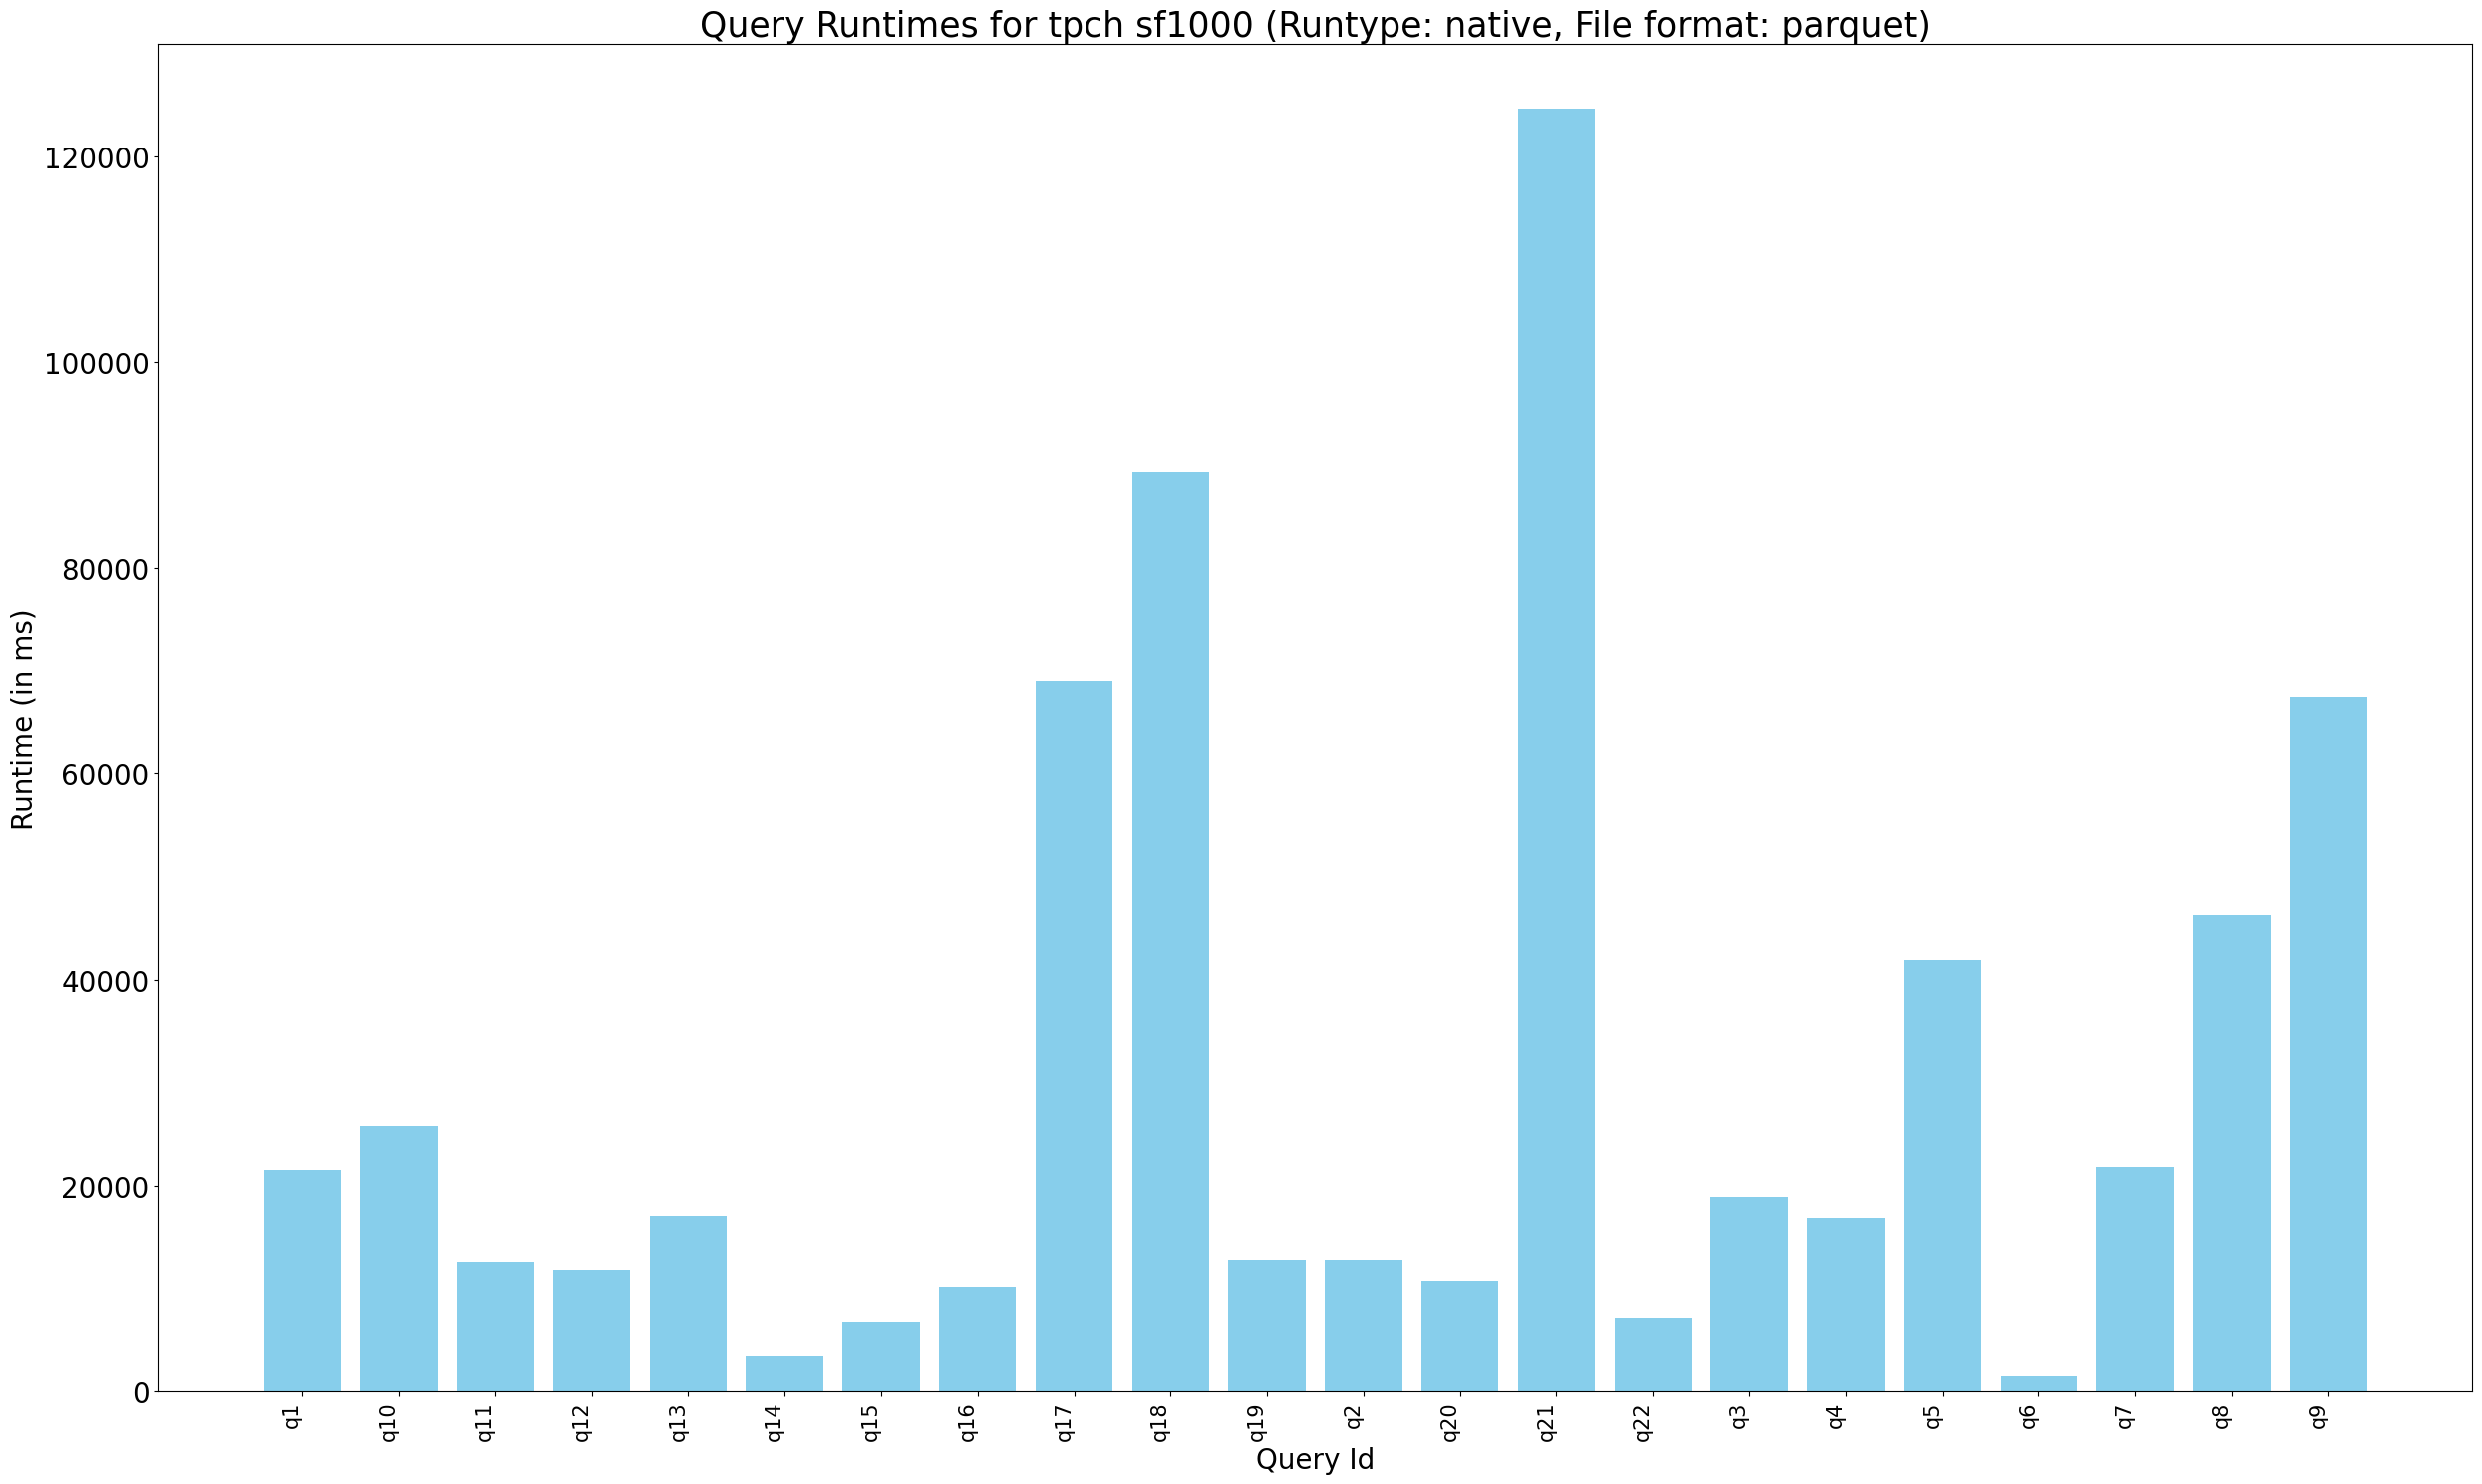

----------------------------------------------------------------------------------------------------------
Writing to GCS bucket sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1
Runtime results successfully written to gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/premium/native/output/parquet/tpch/sf1000/serverless_premium_native_parquet_sf1000_tpch_tpcds_us-east1_2025-08-08_10-39-52.csv
----------------------------------------------------------------------------------------------------------


In [14]:
# Run first benchmark
runTPCBenchmark(spark,first_benchmark,benchmark_configs,BUCKET_NAME,RUN_ID,PROJECT,RUNTYPE,TIER)

if second_benchmark is None: 
    # Call cleanup function
    finalize_notebook_and_cleanup(benchmark_configs,BUCKET_NAME,REGION,PROJECT,RUN_ID,RUNTYPE,TIER)        

### Second Benchmark

#### Start Spark Session

In the following step, spark properties are set to run benchmarks using NQE.

In [15]:
if second_benchmark is not None:
    #  Start new Spark session with specified configurations 
    
    spark_configs = {}
    
    if(size == "sf10000"):
        spark_configs["spark.executor.instances"] = "27"  
    
    spark_builder = SparkSession.builder.appName(f"{second_benchmark} s8s premium with nqe benchmark run").enableHiveSupport()

    for key, value in spark_configs.items():
        spark_builder.config(key, value)
    
    spark = spark_builder.getOrCreate()

    # Set the logger to display only ERROR logs
    logger = sc._jvm.org.apache.logging.log4j
    logger.core.config.Configurator.setAllLevels("org",logger.Level.ERROR)

    print(f"Spark Application Name: {spark.sparkContext.appName}")
    print(f"Spark Session ID: {spark.sparkContext._jsc.sc().applicationId()}")
    print(f"Spark Version: {spark.version}")
    print(f"Spark Master: {spark.sparkContext.master}")
else:
    print("Second benchmark is empty!")
    print("Skipping this step.")      

Setting Spark log level to "ERROR".


Spark Application Name: tpcds s8s premium with nqe benchmark run
Spark Session ID: app-20250808105621-0003
Spark Version: 3.5.1
Spark Master: spark://gdpic-srvls-session-35ad127b-51df-4300-9953-96450fdf1ce3-m:7077


#### Run Benchmark
The following cell runs the second benchmark with the configurations passed.

**NOTE - After every benchmark run is complete, it terminates the existing spark session. New spark session is created for each run.**

Running benchmark: tpcds, size: sf1000, queries to run: all, runtime engine: native, file format: parquet
Setting up TPCDS tables


TPCDS Tables set up
--------Running TPCDS Benchmark with following configurations--------
Queries to run: all
Benchmark: tpcds
Result Location: gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/premium/native/output/parquet/tpcds/sf1000/serverless_premium_native_parquet_sf1000_tpch_tpcds_us-east1_2025-08-08_10-39-52.csv
Scale Factor: sf1000
File Format: parquet
Parquet Tables GCS Path: gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/premium/native
--------------------------------------------------------------------
Running tpcds query q1


tpcds query q1 ran in 6408 ms
Running tpcds query q10


tpcds query q10 ran in 6780 ms
Running tpcds query q11


tpcds query q11 ran in 20679 ms
Running tpcds query q12


tpcds query q12 ran in 2222 ms
Running tpcds query q13


tpcds query q13 ran in 4771 ms
Running tpcds query q14a


tpcds query q14a ran in 22404 ms
Running tpcds query q14b


tpcds query q14b ran in 17746 ms
Running tpcds query q15


tpcds query q15 ran in 2632 ms
Running tpcds query q16


tpcds query q16 ran in 15115 ms
Running tpcds query q17


tpcds query q17 ran in 4046 ms
Running tpcds query q18


tpcds query q18 ran in 5866 ms
Running tpcds query q19


tpcds query q19 ran in 2346 ms
Running tpcds query q2


tpcds query q2 ran in 8065 ms
Running tpcds query q20


tpcds query q20 ran in 1672 ms
Running tpcds query q21


tpcds query q21 ran in 1391 ms
Running tpcds query q22


tpcds query q22 ran in 8181 ms
Running tpcds query q23a


tpcds query q23a ran in 46795 ms
Running tpcds query q23b


tpcds query q23b ran in 64487 ms
Running tpcds query q24a


tpcds query q24a ran in 38545 ms
Running tpcds query q24b


tpcds query q24b ran in 35306 ms
Running tpcds query q25


tpcds query q25 ran in 3309 ms
Running tpcds query q26


tpcds query q26 ran in 3315 ms
Running tpcds query q27


tpcds query q27 ran in 3526 ms
Running tpcds query q28


tpcds query q28 ran in 15577 ms
Running tpcds query q29


tpcds query q29 ran in 6152 ms
Running tpcds query q3


tpcds query q3 ran in 1718 ms
Running tpcds query q30


tpcds query q30 ran in 6765 ms
Running tpcds query q31


tpcds query q31 ran in 5480 ms
Running tpcds query q32
tpcds query q32 ran in 1423 ms
Running tpcds query q33


tpcds query q33 ran in 3184 ms
Running tpcds query q34


tpcds query q34 ran in 3239 ms
Running tpcds query q35


tpcds query q35 ran in 4581 ms
Running tpcds query q36


tpcds query q36 ran in 2772 ms
Running tpcds query q37


tpcds query q37 ran in 2821 ms
Running tpcds query q38


tpcds query q38 ran in 7666 ms
Running tpcds query q39a


tpcds query q39a ran in 4406 ms
Running tpcds query q39b


tpcds query q39b ran in 3749 ms
Running tpcds query q4


tpcds query q4 ran in 35662 ms
Running tpcds query q40


tpcds query q40 ran in 4465 ms
Running tpcds query q41
tpcds query q41 ran in 514 ms
Running tpcds query q42


tpcds query q42 ran in 1075 ms
Running tpcds query q43


tpcds query q43 ran in 2169 ms
Running tpcds query q44


tpcds query q44 ran in 8880 ms
Running tpcds query q45


tpcds query q45 ran in 2948 ms
Running tpcds query q46


tpcds query q46 ran in 2979 ms
Running tpcds query q47


tpcds query q47 ran in 7544 ms
Running tpcds query q48


tpcds query q48 ran in 3269 ms
Running tpcds query q49


tpcds query q49 ran in 7334 ms
Running tpcds query q5


tpcds query q5 ran in 6615 ms
Running tpcds query q50


tpcds query q50 ran in 15178 ms
Running tpcds query q51


tpcds query q51 ran in 7055 ms
Running tpcds query q52
tpcds query q52 ran in 1201 ms
Running tpcds query q53


tpcds query q53 ran in 1893 ms
Running tpcds query q54


tpcds query q54 ran in 3528 ms
Running tpcds query q55
tpcds query q55 ran in 1176 ms
Running tpcds query q56


tpcds query q56 ran in 2893 ms
Running tpcds query q57


tpcds query q57 ran in 5603 ms
Running tpcds query q58


tpcds query q58 ran in 3015 ms
Running tpcds query q59


tpcds query q59 ran in 4468 ms
Running tpcds query q6
tpcds query q6 ran in 2030 ms
Running tpcds query q60


tpcds query q60 ran in 3301 ms
Running tpcds query q61


tpcds query q61 ran in 3079 ms
Running tpcds query q62


tpcds query q62 ran in 2490 ms
Running tpcds query q63


tpcds query q63 ran in 1805 ms
Running tpcds query q64


tpcds query q64 ran in 24901 ms
Running tpcds query q65


tpcds query q65 ran in 9309 ms
Running tpcds query q66


tpcds query q66 ran in 3254 ms
Running tpcds query q67


tpcds query q67 ran in 61178 ms
Running tpcds query q68


tpcds query q68 ran in 2932 ms
Running tpcds query q69


tpcds query q69 ran in 3612 ms
Running tpcds query q7


tpcds query q7 ran in 3119 ms
Running tpcds query q70


tpcds query q70 ran in 5236 ms
Running tpcds query q71


tpcds query q71 ran in 4072 ms
Running tpcds query q72


tpcds query q72 ran in 18058 ms
Running tpcds query q73


tpcds query q73 ran in 2589 ms
Running tpcds query q74


tpcds query q74 ran in 13662 ms
Running tpcds query q75


tpcds query q78 ran in 24695 ms
Running tpcds query q79


tpcds query q79 ran in 2882 ms
Running tpcds query q8


tpcds query q8 ran in 2289 ms
Running tpcds query q80


tpcds query q80 ran in 9279 ms
Running tpcds query q81


tpcds query q81 ran in 4072 ms
Running tpcds query q82


tpcds query q82 ran in 3991 ms
Running tpcds query q83
tpcds query q83 ran in 1931 ms
Running tpcds query q84


tpcds query q84 ran in 2589 ms
Running tpcds query q85


tpcds query q85 ran in 5200 ms
Running tpcds query q86


tpcds query q86 ran in 2096 ms
Running tpcds query q87


tpcds query q87 ran in 7566 ms
Running tpcds query q88


tpcds query q88 ran in 5554 ms
Running tpcds query q89


tpcds query q89 ran in 2306 ms
Running tpcds query q9


tpcds query q9 ran in 10808 ms
Running tpcds query q90


tpcds query q90 ran in 2195 ms
Running tpcds query q91
tpcds query q91 ran in 2555 ms
Running tpcds query q92
tpcds query q92 ran in 1355 ms
Running tpcds query q93


tpcds query q93 ran in 19221 ms
Running tpcds query q94


tpcds query q94 ran in 9304 ms
Running tpcds query q95


tpcds query q95 ran in 21726 ms
Running tpcds query q96


tpcds query q96 ran in 3173 ms
Running tpcds query q97


tpcds query q97 ran in 7981 ms
Running tpcds query q98


tpcds query q98 ran in 2588 ms
Running tpcds query q99


tpcds query q99 ran in 3441 ms
╒═══════════╤══════════════════╕
│ QueryId   │   Runtime(in ms) │
╞═══════════╪══════════════════╡
│ Sum       │           881292 │
├───────────┼──────────────────┤
│ q1        │             6408 │
├───────────┼──────────────────┤
│ q10       │             6780 │
├───────────┼──────────────────┤
│ q11       │            20679 │
├───────────┼──────────────────┤
│ q12       │             2222 │
├───────────┼──────────────────┤
│ q13       │             4771 │
├───────────┼──────────────────┤
│ q14a      │            22404 │
├───────────┼──────────────────┤
│ q14b      │            17746 │
├───────────┼──────────────────┤
│ q15       │             2632 │
├───────────┼──────────────────┤
│ q16       │            15115 │
├───────────┼──────────────────┤
│ q17       │             4046 │
├───────────┼──────────────────┤
│ q18       │             5866 │
├───────────┼──────────────────┤
│ q19       │             2346 │
├───────────┼──────────────────┤
│ q2        

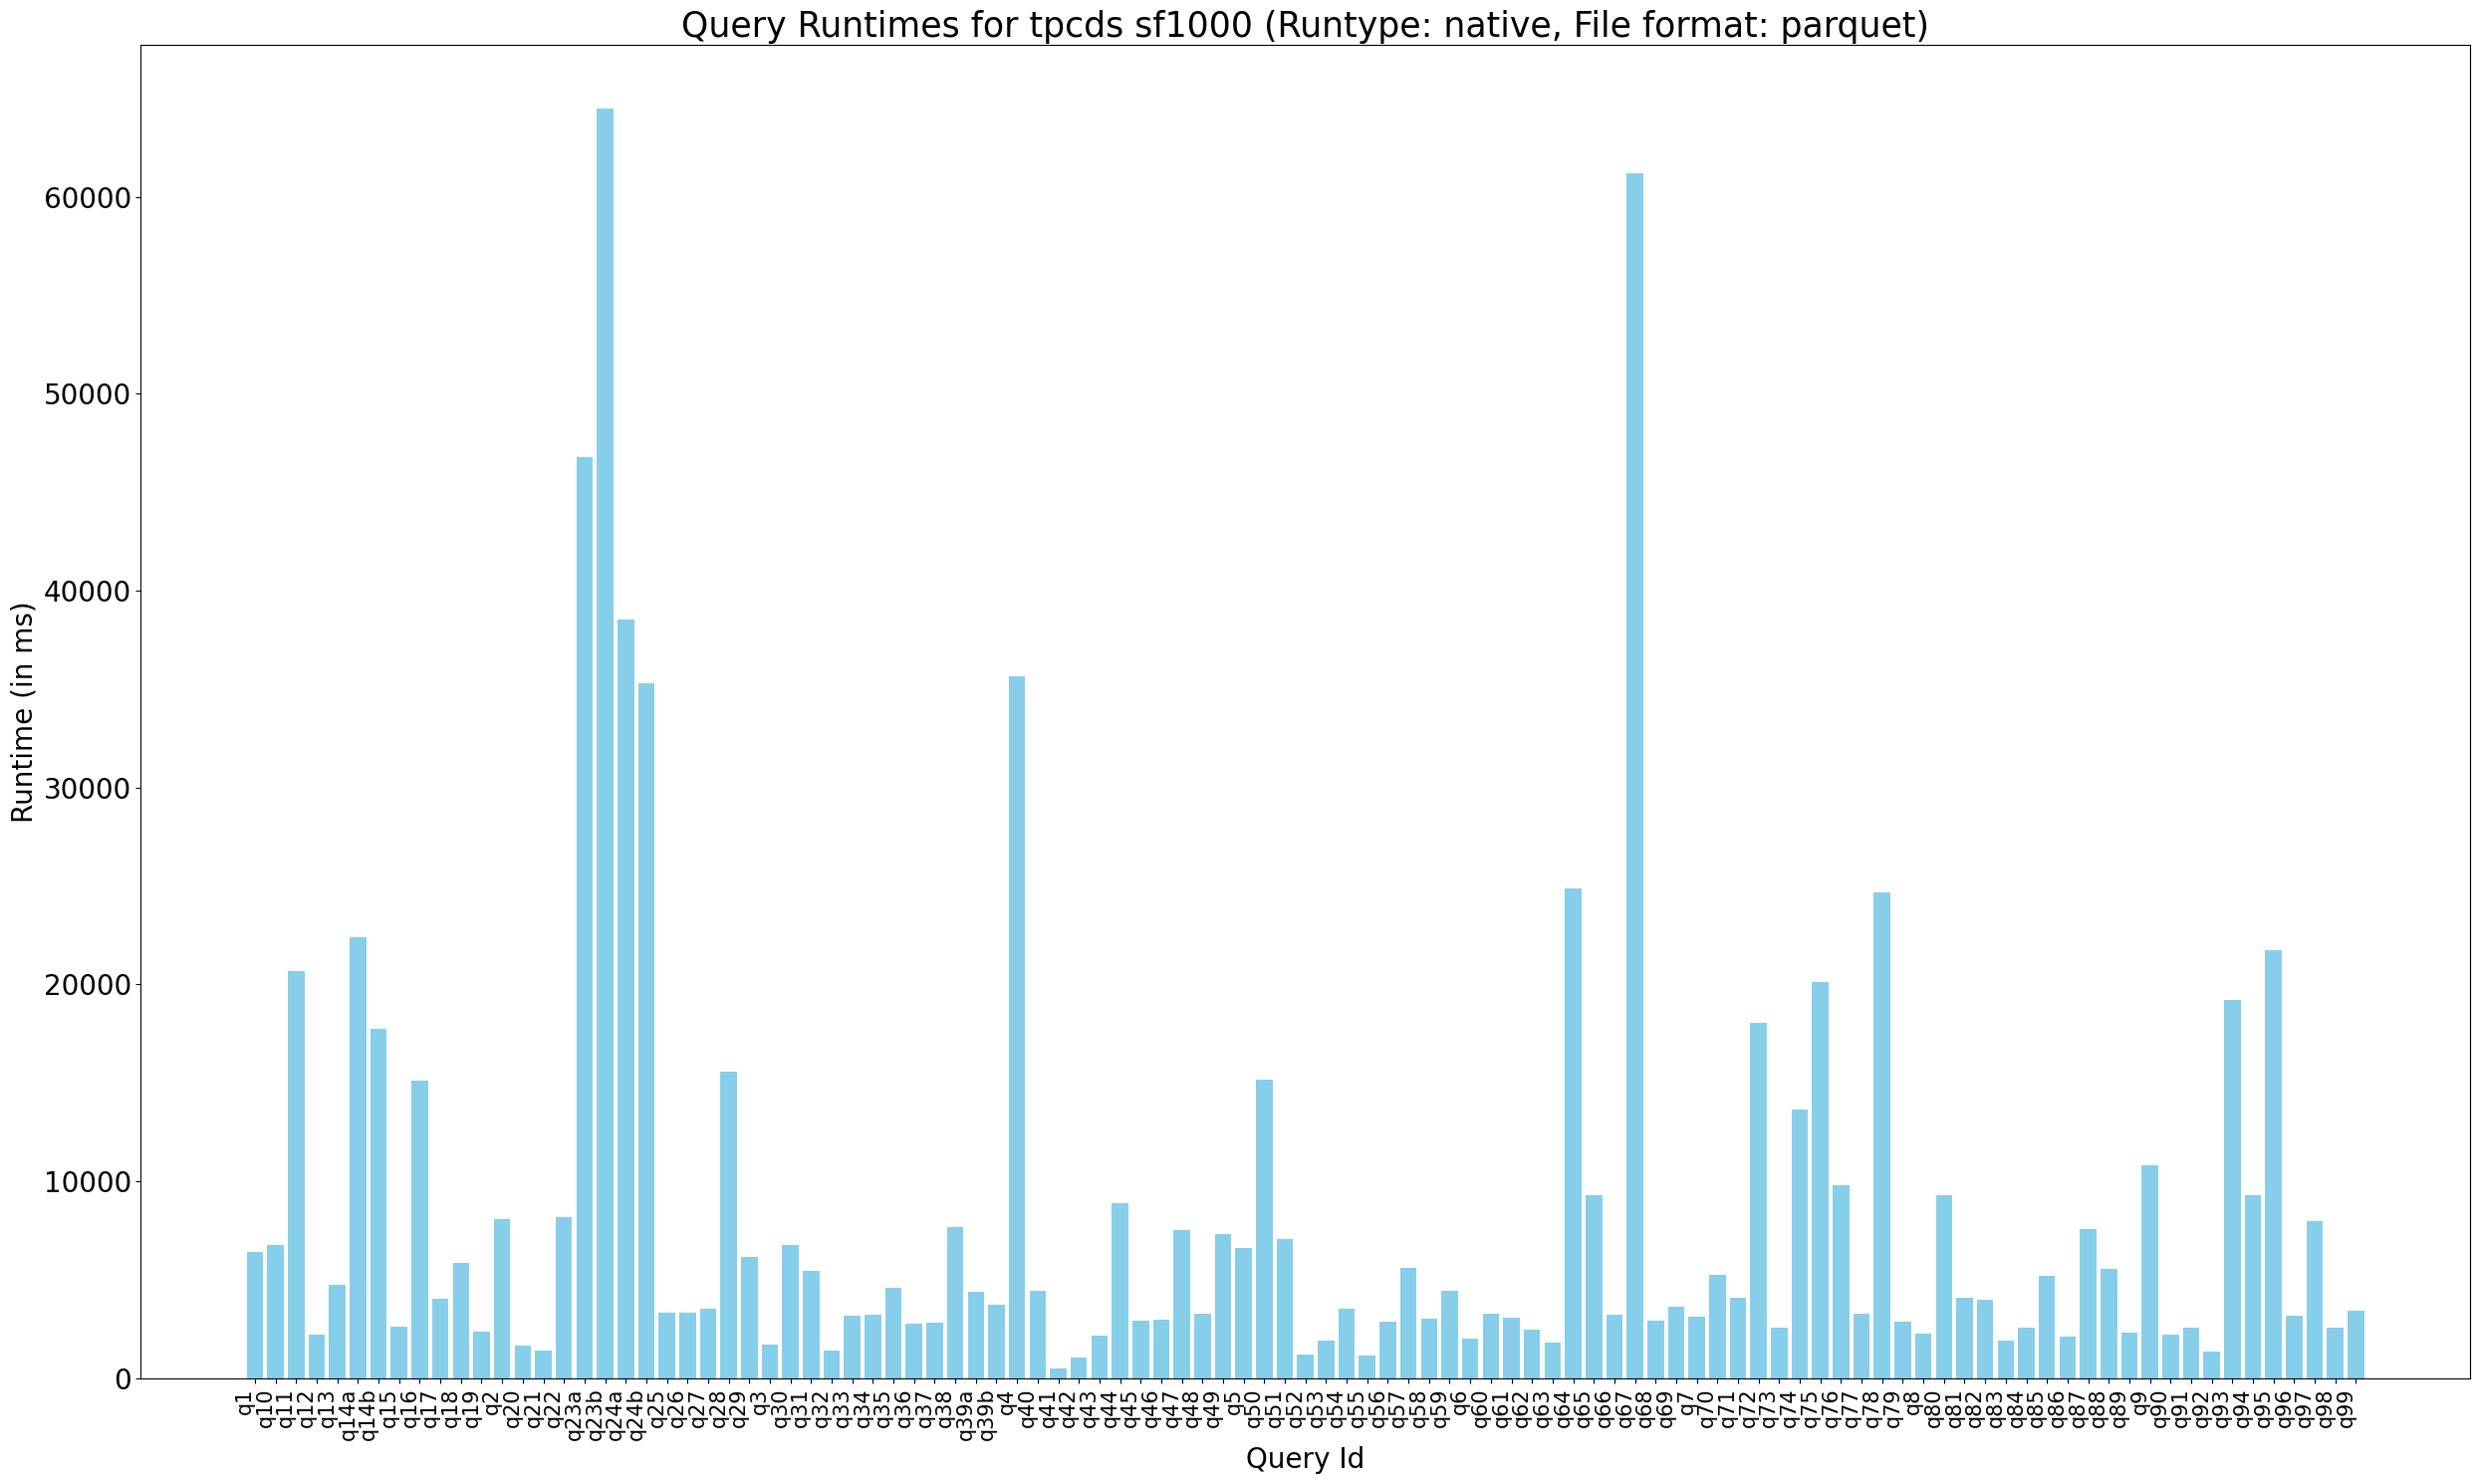

----------------------------------------------------------------------------------------------------------
Writing to GCS bucket sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1
Runtime results successfully written to gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/premium/native/output/parquet/tpcds/sf1000/serverless_premium_native_parquet_sf1000_tpch_tpcds_us-east1_2025-08-08_10-39-52.csv
----------------------------------------------------------------------------------------------------------
Current session name: projects/nishitkamdarargo/locations/us-east1/sessions/9368ac66-3de6-4a63-8571-de8769b48dc3
Uploading session details to GCS...
Uploaded session details to GCS file path gs://sparkpoc-bucket-serverless-premium-nqe-279814974066-us-east1/premium/serverless_native_session/parquet/sf1000/serverless_premium_native_parquet_sf1000_tpch_tpcds_us-east1_2025-08-08_10-39-52.json
-----------------------------------------------------------------------------

In [16]:
if second_benchmark is not None:    
    
    # Run second benchmark
    runTPCBenchmark(spark,second_benchmark,benchmark_configs,BUCKET_NAME,RUN_ID,PROJECT,RUNTYPE,TIER)
    
    # Call cleanup function
    finalize_notebook_and_cleanup(benchmark_configs,BUCKET_NAME,REGION,PROJECT,RUN_ID,RUNTYPE,TIER)
else:
    print("Second benchmark is empty!")
    print("Skipping this step.")        